# Module 7 Activity: Classification

In this module, we will be focusing on a simple classification problem. We will be looking at [Kickstarter Data](https://www.kaggle.com/kemical/kickstarter-projects) and attempting to classify projects as successful or failed based on the different attributes of each project, such as the monetary goal, the number of backers, and how long the project was on Kickstarter.

This is a problem of binary classification, where there are two possible outcomes - success or failure.

In [1]:
# dependencies

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's explore our data a little bit. We'll load it in the cell below.

In [2]:
ks = pd.read_csv('ks_2020.csv')
print(ks.shape)
ks.head()

(261358, 12)


,name,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,duration,name_length
0,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,30000.0,2017-09-02,failed,15,US,30000.0,60,45
1,Where is Hank?,Film & Video,USD,2013-02-26,45000.0,2013-01-12,failed,3,US,45000.0,45,14
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,5000.0,2012-03-17,failed,1,US,5000.0,30,49
3,Monarch Espresso Bar,Food,USD,2016-04-01,50000.0,2016-02-26,successful,224,US,50000.0,35,20
4,Support Solar Roasted Coffee & Green Energy! ...,Food,USD,2014-12-21,1000.0,2014-12-01,successful,16,US,1000.0,20,60


For a classification model, we want to be able to test our model on data that it hasn't seen before. If we try to test it on a point that it already knows the answer for, it'll be correct 100% of the time! For this reason, we split up our data into a training set and a test set. The cell below accomplishes this - it sets aside 10% of the data for testing.

In [3]:
train, test = train_test_split(ks, test_size = 0.1, random_state = 42)

In [4]:
train.head()

,name,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,duration,name_length
245004,KILLER GRANNY: based on our award-winning script,Film & Video,USD,2011-08-21,9900.0,2011-07-22,successful,77,US,9900.0,30,48
178122,"A Facelift for the Facade--Spring Garden Mill,...",Theater,USD,2016-02-20,2000.0,2016-01-30,failed,19,US,2000.0,21,58
115199,The Peter Pomperfield Book Series,Publishing,USD,2014-08-31,1500.0,2014-08-10,failed,1,US,1500.0,21,33
94607,Blender Jar for Blendtec with Replaceable Blad...,Design,USD,2015-04-20,25000.0,2015-03-21,failed,2,US,25000.0,30,52
234415,"Lobo, the Deadliest Assassin",Comics,USD,2015-10-27,10000.0,2015-09-22,failed,2,US,10000.0,35,28


In this module, we'll be implementing a k-nearest neighbors classifier. The idea behind this type of classifier is to look at the k points closest to our point of interest, and classify our point as whatever category the majority of surrounding points are. For example, look at the image of the plot below. The green point has a single nearest neighbor, which is a Sycamore. Of its 5 closest neighbors, 3 are Birch. This would lead us to classify our green point as Birch if we were using KNN with k = 5. 

In our case, rather than classifying trees based on tree diameter and height, we're looking to see if we can classify kickstarter projects as successful or failed.

<p><a href="https://otd.gitbook.io/book/module-7/nearest-neighbors"><img src="knn.PNG"></a></p>

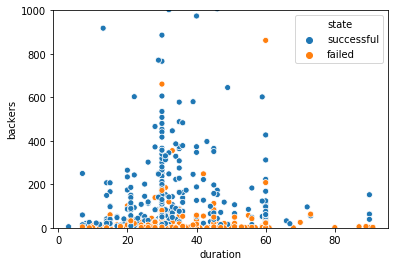

In [5]:
# eda
samp = ks.sample(1000)
sns.scatterplot('duration', 'backers', hue = 'state', data = samp);
plt.ylim(0, 1000);

K-nearest neighbors (KNN) classification works on distances between points, so we'll create a function that tells us the distance between a set of points.

In [31]:
def distance(features_array_1, features_array_2):
    return np.mean(np.sqrt(np.sum((features_array_1 - features_array_2)**2)))

In [7]:
train.head()

,name,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,duration,name_length
245004,KILLER GRANNY: based on our award-winning script,Film & Video,USD,2011-08-21,9900.0,2011-07-22,successful,77,US,9900.0,30,48
178122,"A Facelift for the Facade--Spring Garden Mill,...",Theater,USD,2016-02-20,2000.0,2016-01-30,failed,19,US,2000.0,21,58
115199,The Peter Pomperfield Book Series,Publishing,USD,2014-08-31,1500.0,2014-08-10,failed,1,US,1500.0,21,33
94607,Blender Jar for Blendtec with Replaceable Blad...,Design,USD,2015-04-20,25000.0,2015-03-21,failed,2,US,25000.0,30,52
234415,"Lobo, the Deadliest Assassin",Comics,USD,2015-10-27,10000.0,2015-09-22,failed,2,US,10000.0,35,28


For KNN, we need to select numerical features in order to be able to calculate distances. Our data contain various numerical features, and we'll use all of them - these are `goal`, `backers`, `duration`, and `name_length`. We need to select the columns that contain these features.

In [18]:
train_features = train[['goal', 'backers', 'duration', 'name_length']]
test_features = test[['goal', 'backers', 'duration', 'name_length']]

For the first Kickstarter project in our dataset, the 'KILLER GRANNY: based on our award-winning script', we'll compute the distance to the rest of the projects in the dataset.

In [19]:
train_features

,goal,backers,duration,name_length
245004,9900.0,77,30,48
178122,2000.0,19,21,58
115199,1500.0,1,21,33
94607,25000.0,2,30,52
234415,10000.0,2,35,28
...,...,...,...,...
259178,100000.0,1,60,13
103694,10000.0,103,30,27
131932,5500.0,9,31,34
146867,3000.0,136,24,60


In [20]:
# distance between first and second projects
train_features.iloc[0]

goal           9900.0
backers          77.0
duration         30.0
name_length      48.0
Name: 245004, dtype: float64

In [21]:
train_features.iloc[1]

goal           2000.0
backers          19.0
duration         21.0
name_length      58.0
Name: 178122, dtype: float64

In [22]:
distance(train_features.iloc[0], train_features.iloc[1])

7900.224363902585

In [23]:
# have to somehow norm the values or else the distances will be v skewed
def standard_units(array):
    m = np.mean(array)
    sd = np.std(array)
    return (array - m)/sd

In [24]:
train_features = train_features.apply(standard_units)
test_features = test_features.apply(standard_units)

In [42]:
distance(train_features.iloc[0], train_features.iloc[1])

0.9370751805569747

In [43]:
 distance(test_features.iloc[0], train_features)

674.804802796899

Looking at the distance of the first project to all subsequent projects

In [46]:
train_features.shape[0]

235222

In [48]:
d = []
for i in range(1, train_features.shape[0]+1):
    d.append(distance(test_features.iloc[0], train_features.iloc[i]))

KeyboardInterrupt: 

In [39]:
train_features.shape[1]

4

In [41]:
fast_distances(test_features.iloc[0], train_features)

TypeError: unsupported operand type(s) for -: 'float' and 'str'